In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [2]:
# import deeplake
# ds = deeplake.load("hub://activeloop/ffhq")
# ds.summary()
# print(ds.tensors['images_128/image'].shape)

In [3]:
dirpath = 'images/thumbnails_jpg'
filenames = os.listdir(dirpath)
N_IMGS = 100
img_paths = [dirpath + f"/{filename}" for filename in filenames[:N_IMGS]]
print(f"Keeping {len(img_paths)} images out of {len(filenames)}")

Keeping 100 images out of 70000


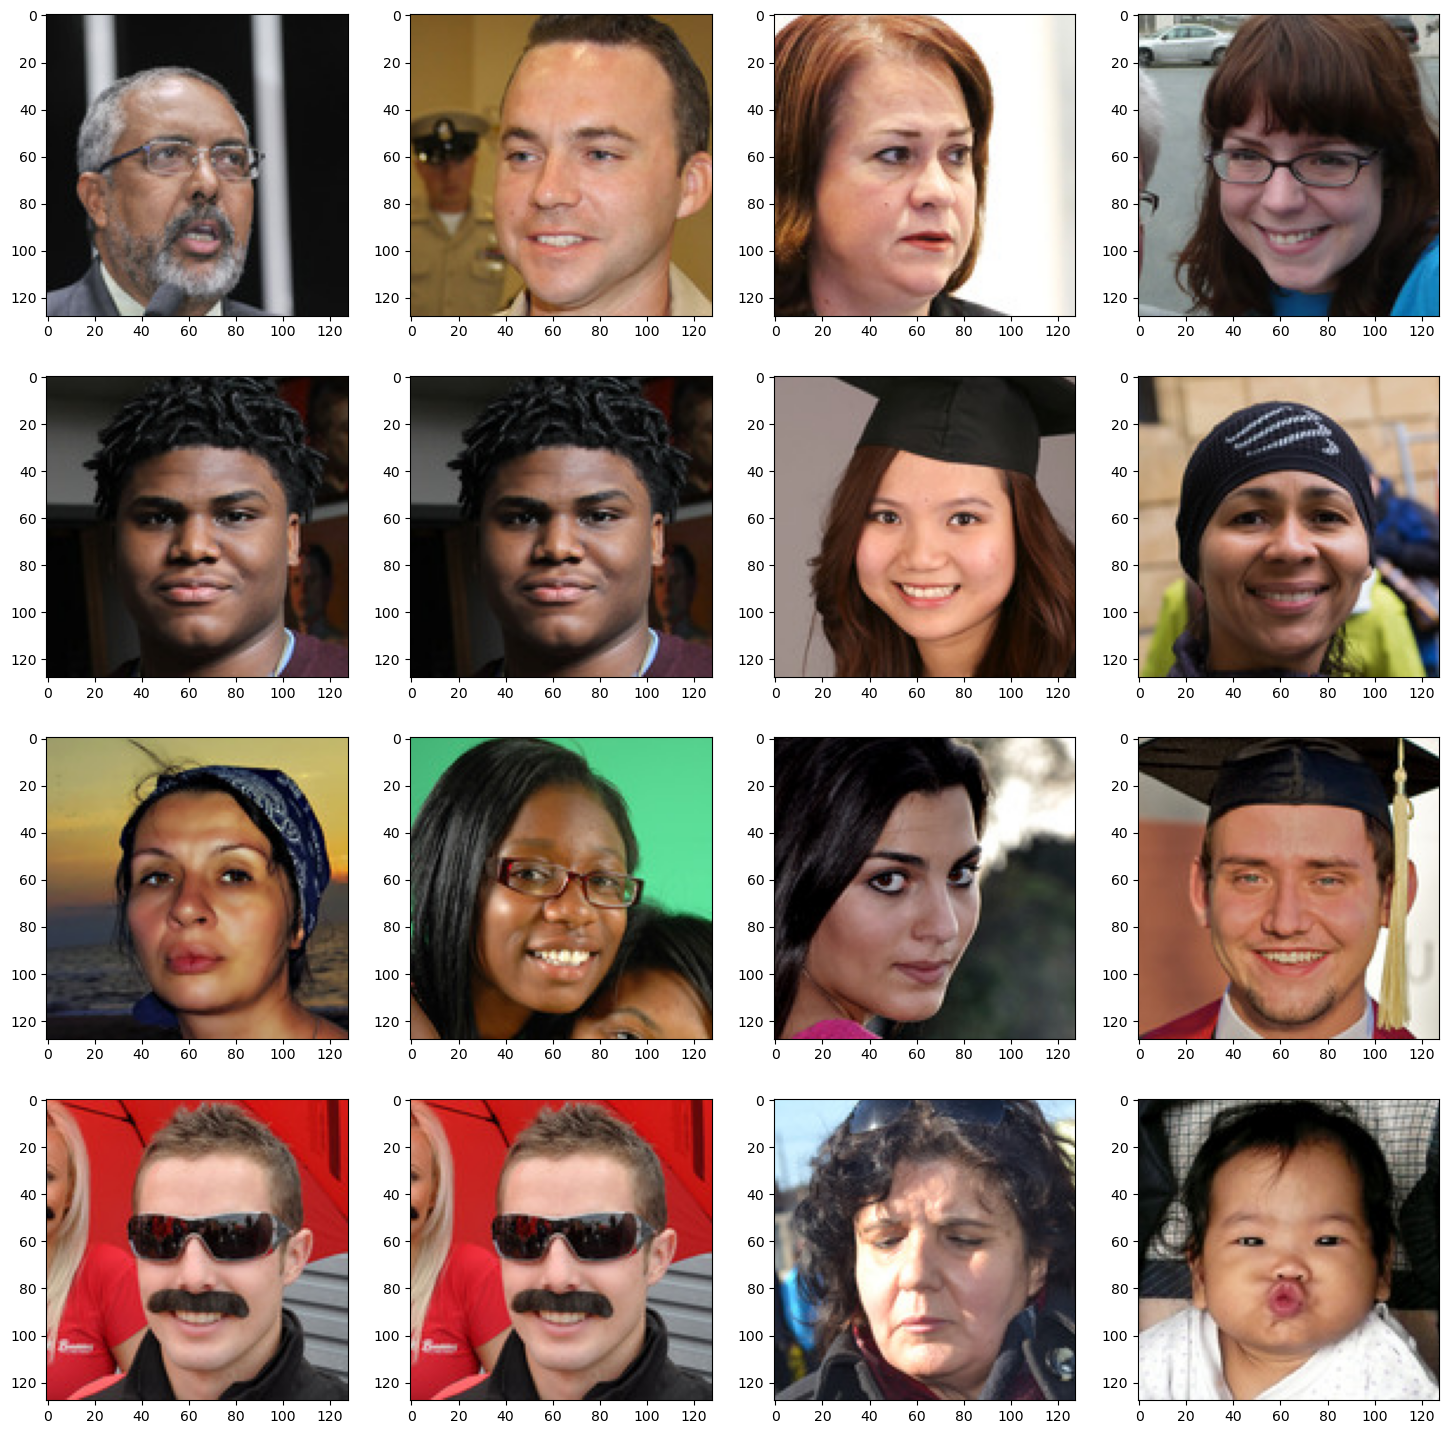

In [4]:
fix, axes = plt.subplots(4, 4, figsize=(18, 18))
samples = [img_paths[i] for i in np.random.randint(0, N_IMGS, size=16)]
for i, sample in enumerate(samples):
    image = cv2.imread(sample)
    axes.flat[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
H, W = 128, 128  # Not sure if H, W or W, h
X = np.zeros((N_IMGS, 128, 128, 3), dtype=np.uint8)
for i, path in tqdm(enumerate(img_paths), total=N_IMGS):
    img = cv2.imread(path)
    X[i] = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 504.34it/s]


In [6]:
from keras.layers import Conv2D, UpSampling2D, InputLayer
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

In [7]:
#Design the neural network
model = Sequential()
model.add(InputLayer(input_shape=(128, 128, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
# Finish model
model.compile(optimizer='rmsprop', loss='mse')

2022-10-25 17:55:13.085003: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 17:55:13.085834: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 512)       1

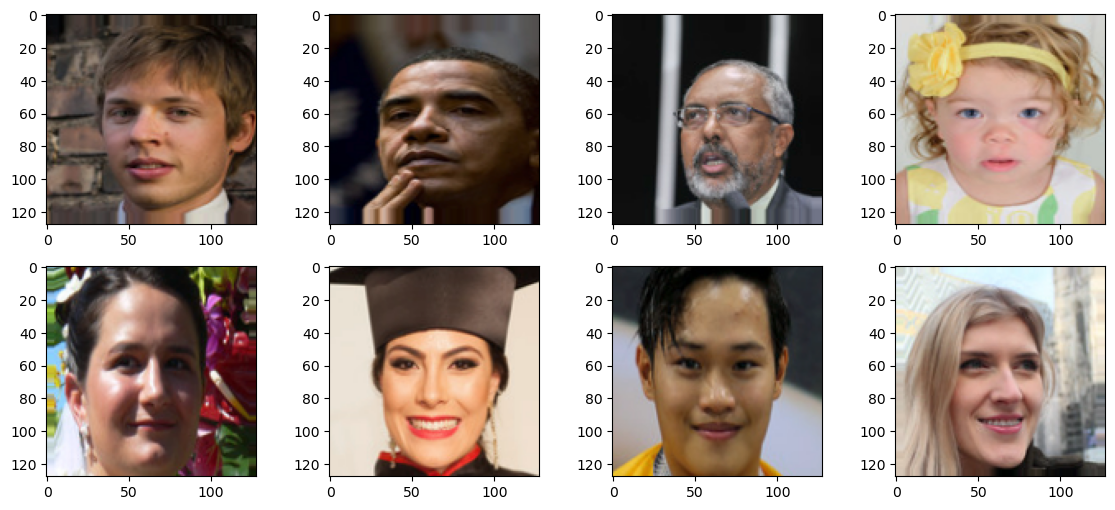

In [11]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        # rotation_range=20,
        horizontal_flip=True)

# Generate training data
def image_gen(X, batch_size):
    for batch in datagen.flow(X, batch_size=batch_size):
        lab_batch = [cv2.cvtColor(img, cv2.COLOR_BGR2Lab) for img in batch]
        lab_batch = np.array(lab_batch)
        # Input: Keeping L channel
        X_batch = lab_batch[:, :, :, 0][:, :, :, np.newaxis]  
        # Target: Keeping a and b channels
        Y_batch = lab_batch[:, :, :, 1:]
        yield X_batch, Y_batch / 128

# Display some examples of transformation
fix, axes = plt.subplots(2, 4, figsize=(14, 6))
for i in range(8):
    image = cv2.cvtColor(next(datagen.flow(X, batch_size=1))[0].astype(np.uint8), cv2.COLOR_Lab2RGB)
    axes.flat[i].imshow(image)
plt.show()

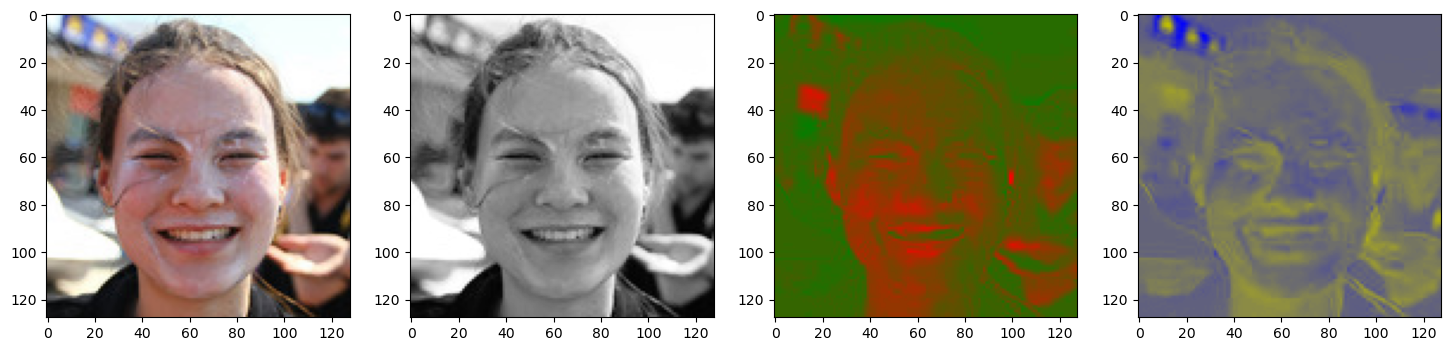

In [12]:
from  matplotlib.colors import LinearSegmentedColormap
cmap_a=LinearSegmentedColormap.from_list('gr',["g", "r"], N=256) 
cmap_b=LinearSegmentedColormap.from_list('by',["b", "y"], N=256) 

sample = cv2.imread(img_paths[4])
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2Lab)[:, :, 0], cmap='gray')
axes[2].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2Lab)[:, :, 1], cmap=cmap_a)
axes[3].imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2Lab)[:, :, 2], cmap=cmap_b);

In [13]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [4]:
!which tensorboard

In [5]:
# %load_ext tensorboard
# %tensorboard --logdir logs
# %tensorboard --logdir logs/fit
model.fit(image_gen(X, batch_size=64), epochs=1, steps_per_epoch=100, callbacks=[tensorboard_callback], verbose=1)

UsageError: Line magic function `%tensorboard` not found.
